In [1]:
# from google.colab import drive
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import random
import numpy as np
from scipy import signal
import numpy as np
# import numexpr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from keras.layers import *
from keras.models import *
from sklearn.preprocessing import MinMaxScaler
# import h5py

from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/MyDrive/Traffic_data'

Mounted at /content/drive


In [ ]:
#  import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seed = 1024
# nrows = 150159
nrows = 4000
feature_names = ['ego_x',"ego_v", 'f_dx', 'f_dy', 'f_dv', 'b_dx', 'b_dy','b_dv', 'l_dx', 'l_dy', 'l_dv', 'r_dx', 'r_dy', 'r_dv']
# Label1: Ego vehicle lateral displacement
label_names_1 = ['ego_x']

# Label2: Ego vehicle longitudinal velocity
label_names_2 = ['ego_v']
# label_name = 'ego_v'
time_columns = "index"

full_path = Path+'/Final_result.xlsx' 

###############################
# nrows = 150158+1
################################


train_rows=int(nrows*0.8) 
train_model =True  
load_model = False 

learning_rate = 0.001

batch_size = 1 # batch_size
require_improvement_epoch = 5 
num_epochs = 100 
ealry_stop = True

hidden_dim = 100 
target_dim = 1 
num_heads = 4

epoch_no=200
batch_size_RNN=32

n_in = 10 
n_out = 5

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from sklearn.preprocessing import MinMaxScaler
import h5py
df = pd.read_excel(full_path,parse_dates=[time_columns],nrows=nrows)
df = df.sort_values(time_columns)
df.index = np.arange(df.shape[0])

In [ ]:
df2=df.iloc[:5000,:]

In [ ]:
df2

,index,ego_x,ego_v,f_dx,f_dy,f_dv,b_dx,b_dy,b_dv,l_dx,l_dy,l_dv,r_dx,r_dy,r_dv
0,0,51.816071,34.006429,30.000000,300.000000,0.000000,0.561490,0.561490,2.236814,-13.171722,-13.171722,0.154693,30.000000,300.000000,0.000000
1,1,52.726857,35.324286,30.000000,300.000000,0.000000,-1.311634,-1.311634,-0.999323,-13.838332,-13.838332,-0.283392,30.000000,300.000000,0.000000
2,2,53.001810,37.491429,30.000000,300.000000,0.000000,-2.030706,-2.030706,-4.150722,-13.980892,-13.980892,-2.208976,30.000000,300.000000,0.000000
3,3,56.291381,39.865238,30.000000,300.000000,0.000000,-5.374435,-5.374435,-6.864538,-17.218590,-17.218590,-4.814726,30.000000,300.000000,0.000000
4,4,29.079835,33.970674,30.000000,300.000000,0.000000,1.012832,1.012832,2.269220,-10.292661,-10.292661,4.718274,9.564515,9.564515,0.190448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,42.137802,35.090304,-0.221069,-0.221069,-6.712233,0.636319,0.636319,2.623670,-9.622777,-9.622777,-5.764678,10.232875,10.232875,-3.073664
3996,3996,42.308804,34.116095,-0.588101,-0.588101,-6.216717,0.579364,0.579364,3.112242,-9.612632,-9.612632,-4.431115,10.159946,10.159946,-0.514571
3997,3997,42.443980,32.614500,-1.003208,-1.003208,-4.905719,0.499540,0.499540,3.930849,-9.528238,-9.528238,-2.936426,10.095887,10.095887,2.388405
3998,3998,42.514493,30.974881,-1.423989,-1.423989,-3.315690,0.440175,0.440175,4.465308,-9.353846,-9.353846,-1.775935,10.111250,10.111250,5.294472


In [ ]:
#Normalization
scaler_y_1 = MinMaxScaler(feature_range=(-1, 1))
scaler_y_1.fit(df2[label_names_1].values.astype(float))

scaler_y_2 = MinMaxScaler(feature_range=(-1, 1))
scaler_y_2.fit(df2[label_names_2].values.astype(float))

scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_x.fit(df2[feature_names].values.astype(float))

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
## Create dataset
def create_dataset(df,feature_names,label_names_1,label_names_2,n_in,n_out,scaler_x=None,scaler_y_1 = None,scaler_y_2 = None):
  X, Y1, Y2 = [], [], []
  for i in tqdm(range(df.shape[0]-n_in-n_out+1)):
    # x_train.append(np.array(df[feature_names].iloc[i:i+n_in]))
    x = df[feature_names].values[i:i+n_in].astype(float)
    x = scaler_x.transform(x)
    label1 = df[label_names_1].values[i+n_in:i+n_in+n_out].astype(float)
    label1 = scaler_y_1.transform(label1)
    label2 = df[label_names_2].values[i+n_in:i+n_in+n_out].astype(float)
    label2 = scaler_y_2.transform(label2)
    # label = scaler_y.transform(label.reshape(-1,1)).reshape(-1)
    X.append(x)
    Y1.append(label1)
    Y2.append(label2)

    # break
  return np.array(X),np.array(Y1),np.array(Y2)

In [ ]:
X_1,Y1,Y2 = create_dataset(df2,feature_names,label_names_1,label_names_2,10,5,scaler_x,scaler_y_1,scaler_y_2)

100%|██████████| 3986/3986 [00:12<00:00, 322.43it/s]


In [ ]:
x1_train, x1_test = X_1[:train_rows], X_1[train_rows:]
y1_train, y1_test = Y1[:train_rows], Y1[train_rows:]
y2_train, y2_test = Y2[:train_rows], Y2[train_rows:]
print(x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape,y2_train.shape,y2_test.shape)

(3200, 10, 14) (786, 10, 14) (3200, 5, 1) (786, 5, 1) (3200, 5, 1) (786, 5, 1)


In [ ]:
# out=5,y1 ae-lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector,TimeDistributed
y1_train=y1_train.reshape((y1_train.shape[0],y1_train.shape[1]))
# Initialising the RNN
regressor3 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=100
regressor3.add(Bidirectional(LSTM(units = layer_1_units, input_shape = (x1_train.shape[1], x1_train.shape[2]))))
regressor3.add(RepeatVector(5))
regressor3.add(Bidirectional(LSTM(layer_1_units, activation='relu', return_sequences=True)))
regressor3.add(TimeDistributed(Dense(1)))

# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor3.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# epoch_no=20
# batch_size_RNN=64
model3=regressor3.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/200
100/100 [==============================] - 9s 26ms/step - loss: 0.0671
Epoch 2/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0422
Epoch 3/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0370
Epoch 4/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0347
Epoch 5/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0331
Epoch 6/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0329
Epoch 7/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0318
Epoch 8/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0309
Epoch 9/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0303
Epoch 10/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0294
Epoch 11/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0283
Epoch 12/200
100/100 [==============================] - 3s 26ms/step - loss: 0.0285
E

In [ ]:

trainPredict3 = regressor3.predict(x1_train)

trainPredict3=trainPredict3.reshape(trainPredict3.shape[0],trainPredict3.shape[1])

y1_train_cnt =  scaler_y_1.inverse_transform(y1_train.reshape(-1, 5))
# y2_train_cnt =  scaler_y_2.inverse_transform(y2_train.reshape(-1, 5))
# trainPredict_cnt = scaler_y_1.inverse_transform(trainPredict)

trainPredict3_cnt = scaler_y_1.inverse_transform(trainPredict3)


<function matplotlib.pyplot.show>

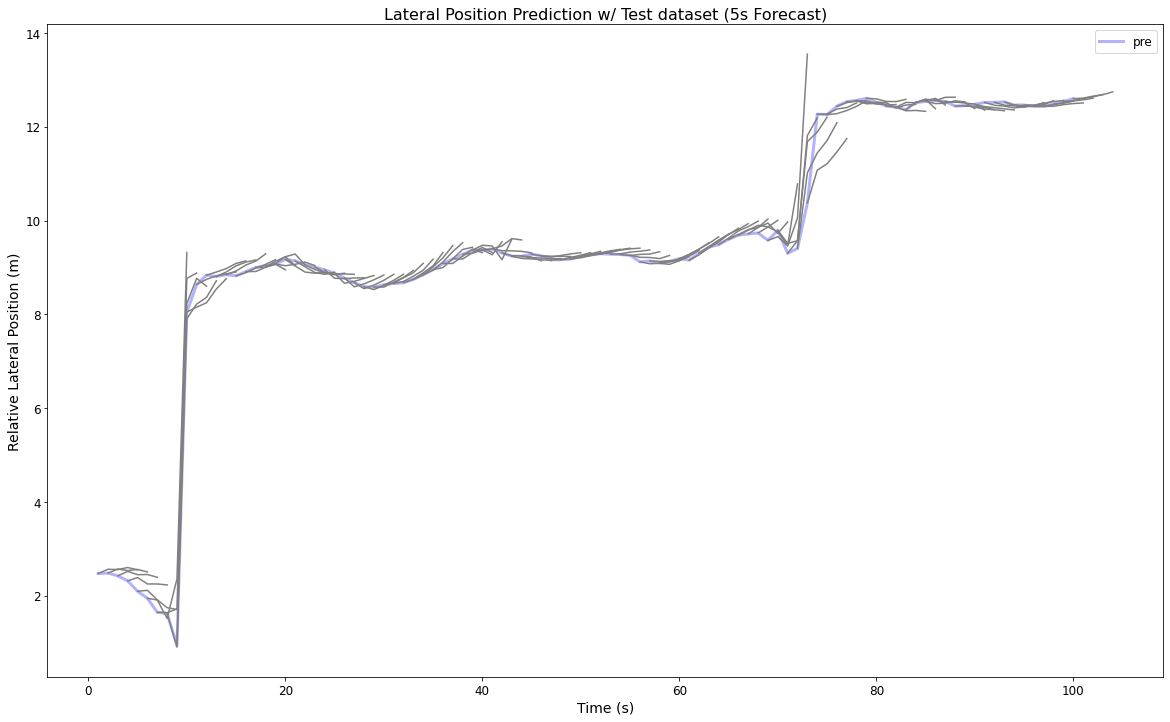

In [ ]:
plt.figure(figsize=(20, 12))  
# plt.plot(range(1,21),y1_train_cnt[2200:2220,0]/3.28084,label='GT')
plt.plot(range(1,101),trainPredict3_cnt[2200:2300,0]/3.28084,'blue',label='pre',linewidth = 3, alpha=0.3)
# plt.plot(range(10,180),testPredict_10_x_act[10200:10370,9]/3.28084,'green',label='Forecast = 10s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2200,2300):
  # plt.plot(y1_test_act[i][:]/3.28084)
  plt.plot(range(m,m+5),trainPredict3_cnt[i][:]/3.28084,'gray')
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

<function matplotlib.pyplot.show>

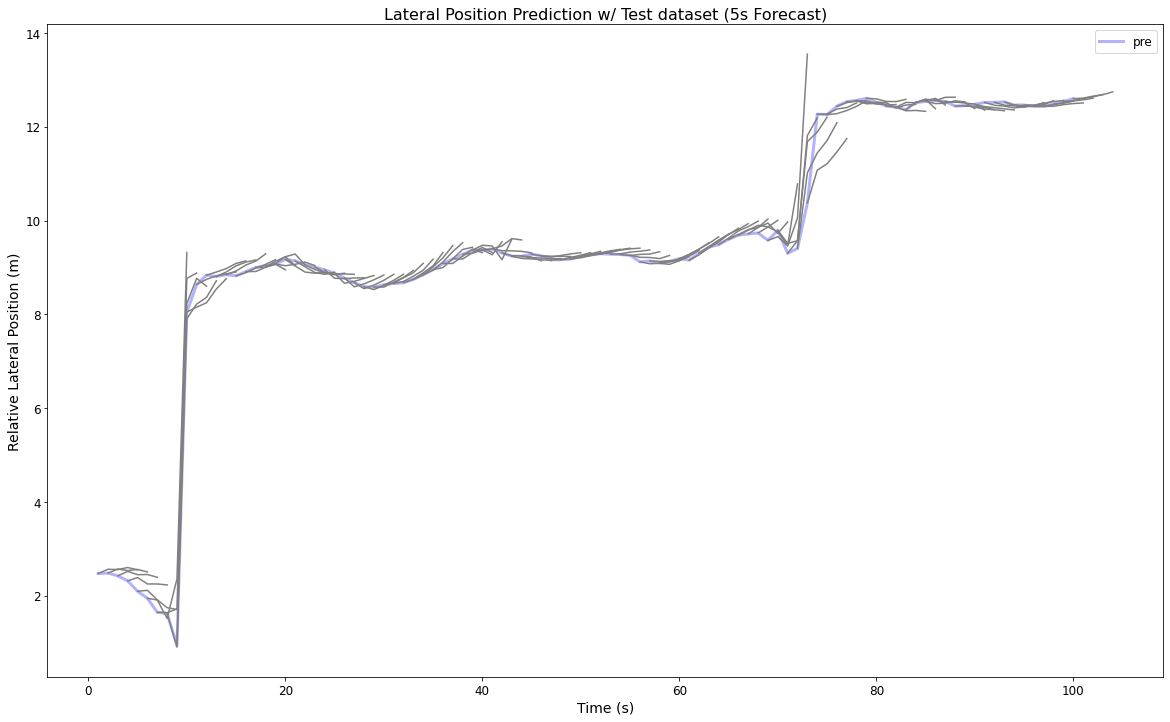

In [ ]:
plt.figure(figsize=(20, 12))  
# plt.plot(range(1,21),y1_train_cnt[2200:2220,0]/3.28084,label='GT')
plt.plot(range(1,101),trainPredict3_cnt[2200:2300,0]/3.28084,'blue',label='pre',linewidth = 3, alpha=0.3)
# plt.plot(range(10,180),testPredict_10_x_act[10200:10370,9]/3.28084,'green',label='Forecast = 10s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2200,2300):
  # plt.plot(y1_test_act[i][:]/3.28084)
  plt.plot(range(m,m+5),trainPredict3_cnt[i][:]/3.28084,'gray')
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

<function matplotlib.pyplot.show>

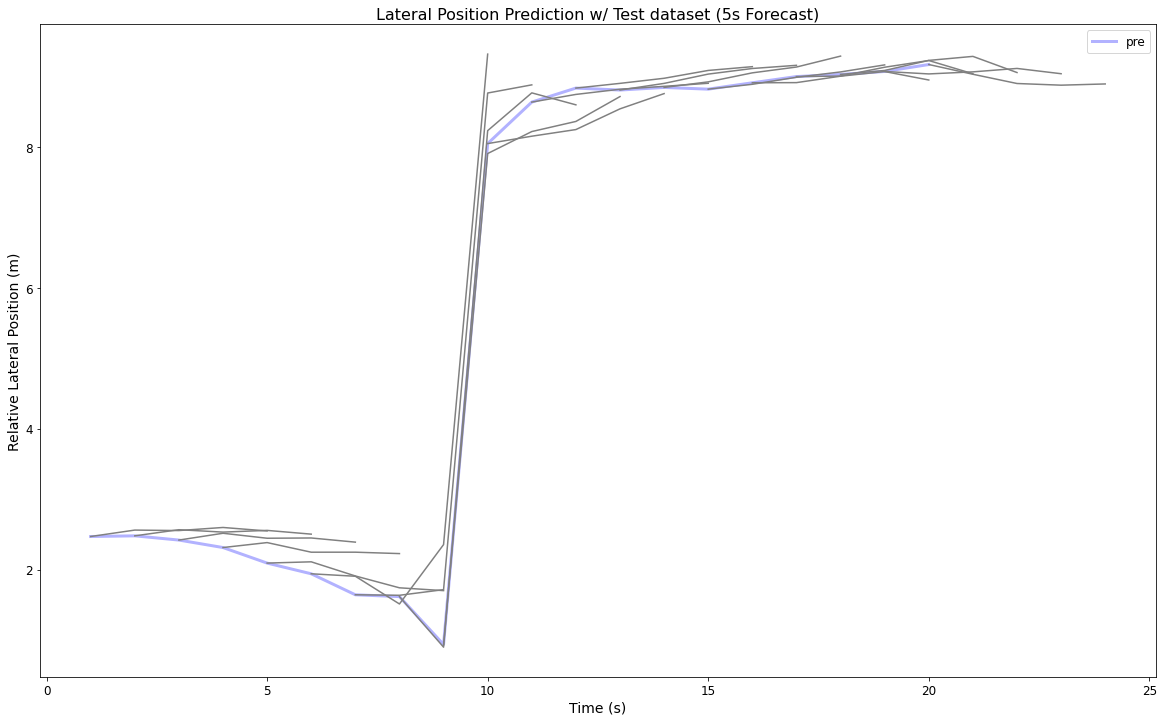

In [ ]:
plt.figure(figsize=(20, 12))  
# plt.plot(range(1,21),y1_train_cnt[2200:2220,0]/3.28084,label='GT')
plt.plot(range(1,21),trainPredict3_cnt[2200:2220,0]/3.28084,'blue',label='pre',linewidth = 3, alpha=0.3)
# plt.plot(range(10,180),testPredict_10_x_act[10200:10370,9]/3.28084,'green',label='Forecast = 10s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2200,2220):
  # plt.plot(y1_test_act[i][:]/3.28084)
  plt.plot(range(m,m+5),trainPredict3_cnt[i][:]/3.28084,'gray')
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show